### Задача:

Построить модель нейронной сети, предсказывающую поломку программного обеспечения по его анонимным признакам. В данной задаче необходимо оптимизировать метрику ROC_AUC.

### План решения:

1. Загрузите данные. Проведите EDA по вашему датасету, опишите основные идеи для последующей генерации новых признаков.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

In [2]:
df = pd.read_csv('train_3.2.csv')
df.sample(10).T

,71801,48649,11209,92857,73262,57840,49683,1861,99219,41356
id,71801,48649,11209,92857,73262,57840,49683,1861,99219,41356
loc,22.0,11.0,38.0,20.0,18.0,23.0,12.0,17.0,22.0,34.0
v(g),3.0,1.0,7.0,1.0,2.0,4.0,1.0,2.0,4.0,9.0
ev(g),3.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
iv(g),2.0,1.0,2.0,1.0,2.0,4.0,1.0,2.0,2.0,6.0
n,61.0,44.0,0.0,68.0,41.0,117.0,28.0,60.0,39.0,0.0
v,249.73,191.16,0.0,330.34,182.84,554.48,112.0,294.41,165.67,0.0
l,0.08,0.09,0.0,0.08,0.12,0.06,0.18,0.07,0.1,0.0
d,12.07,11.59,0.0,12.59,8.25,17.06,5.5,13.5,10.0,0.0
i,20.04,14.16,0.0,26.23,21.27,36.65,20.36,23.38,16.42,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

In [4]:
df.duplicated().sum()

0

Все данные числовые.

Пропуски и дубликаты в данных отсутствуют.

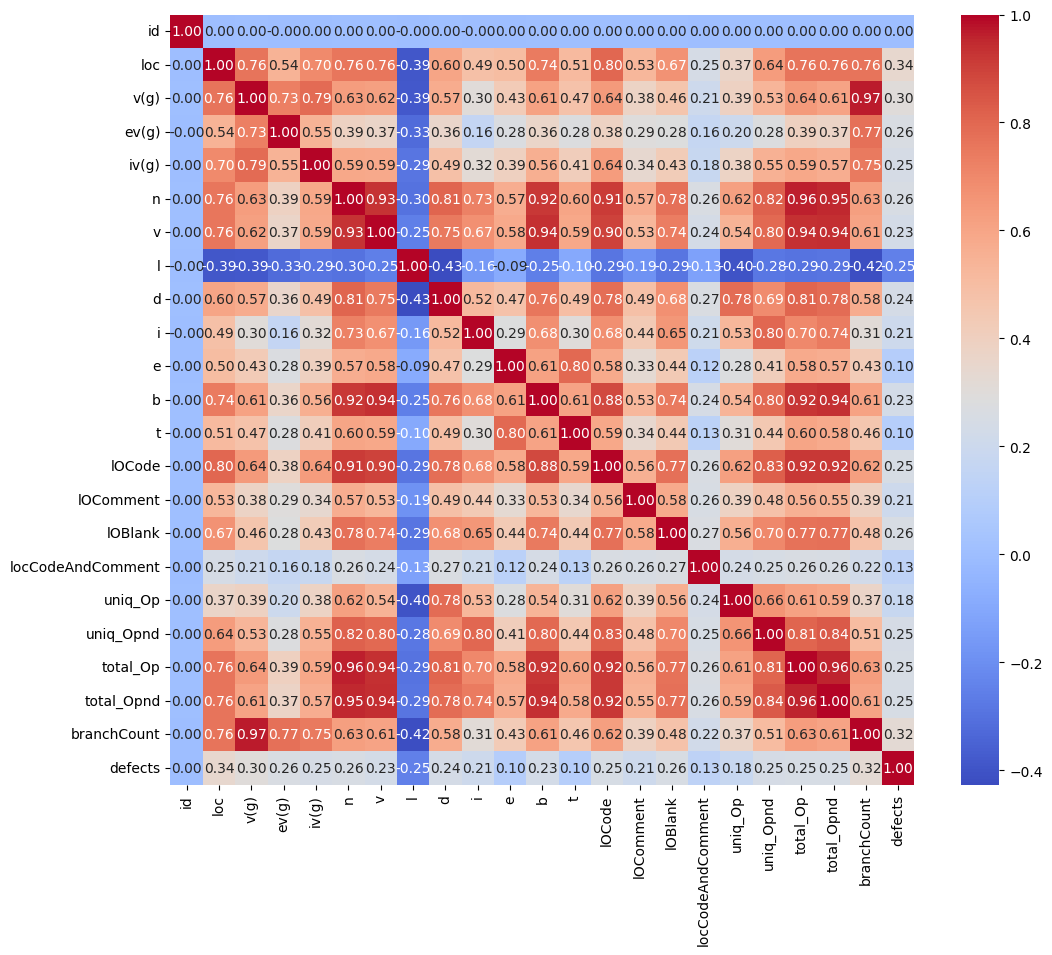

In [5]:
# Корреляционная матрица
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


Очевидно, что столбец 'id' не имеет функциональной значимости. Его нужно будет удалить.

Также, из-за высокой зависимости признаков друг от друга можно будет избавиться от столбцов 'v(g)', 'total_Op', 'v', 'b'.

2. Проведите разбиение на тренировочные и валидационные данные. Проведите необходимую предобработку данных для последующего обучения нейронной сети.

In [6]:
features = df.drop(['defects', 'id'], axis=1)
target = 1 * df.defects

In [7]:
target.value_counts()

defects
0    78699
1    23064
Name: count, dtype: int64

Классы целевой переменной несбалансированы.

In [8]:
# Получим веса классов для дальнейшего использования в модели
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(target), y=target)
class_weights

array([0.64653299, 2.20610042])

In [9]:
features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=0.2, random_state=42,stratify=target)

Отмасштабируем признаки

In [10]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)

3. Реализуйте функцию, в которой вы будете определять архитектуру модели. Функция должна возвращать скомпилированную модель.

In [11]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1], )))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['auc'])
    
    return model

4. Обучите модель нейронной сети (без использования методов регуляризации) на исходной тренировочной выборке (без добавления новых признаков). В процессе обучения нужно отслеживать метрику ROC_AUC на каждой эпохе, на валидационных данных.

In [12]:
model = create_model()

history = model.fit(features_train, target_train.to_numpy(),
                    validation_data=(features_val, target_val.to_numpy()), 
                    epochs=25,
                    batch_size=64, 
                    class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - auc: 0.7707 - loss: 0.5672 - val_auc: 0.7896 - val_loss: 0.5740
Epoch 2/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.7889 - loss: 0.5539 - val_auc: 0.7896 - val_loss: 0.5339
Epoch 3/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.7880 - loss: 0.5534 - val_auc: 0.7887 - val_loss: 0.5730
Epoch 4/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7834 - loss: 0.5588 - val_auc: 0.7893 - val_loss: 0.5367
Epoch 5/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7883 - loss: 0.5539 - val_auc: 0.7909 - val_loss: 0.5458
Epoch 6/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.7910 - loss: 0.5513 - val_auc: 0.7909 - val_loss: 0.5649
Epoch 7/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7926 - loss: 0.5507 - val_auc: 0.7907 - val_loss: 0.5448
Epoch 8/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7903 - loss: 0.5512 - val_auc: 0.7915 - val_loss: 0.5622
Epoch 9/25
1273/1273 ━━━━━━━━━━━━━━━━━━

In [13]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, label=f'Training {figure_name}', color=(1.0, 0.0, 0.0, 1))
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

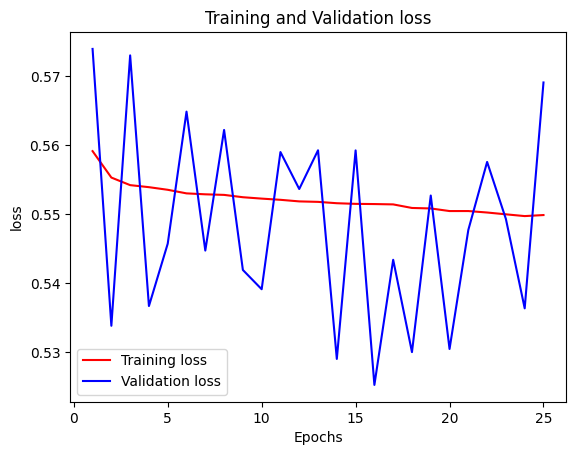

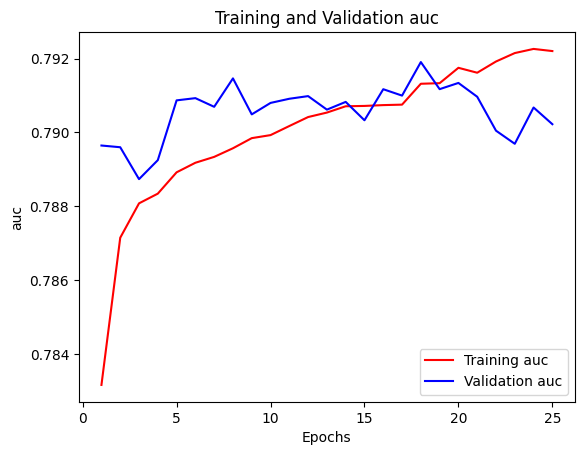

In [14]:
check_metrics(history, 'loss')
check_metrics(history, 'auc')

In [15]:
model.predict(features_val)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.9298692 ],
       [0.31936947],
       [0.8226109 ],
       ...,
       [0.25035593],
       [0.6318294 ],
       [0.28413028]], dtype=float32)

In [16]:
treshold = 0.5
target_pred = [1 if i > treshold else 0 for i in model.predict(features_val)]

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
print(classification_report(target_val, np.round(target_pred)))

              precision    recall  f1-score   support

           0       0.89      0.75      0.82     15740
           1       0.45      0.69      0.55      4613

    accuracy                           0.74     20353
   macro avg       0.67      0.72      0.68     20353
weighted avg       0.79      0.74      0.75     20353



In [18]:
print(f'ROC AUC на тренировочной части: {model.evaluate(features_train, target_train.to_numpy(), verbose=0)[1]}')
print(f'ROC AUC на тестовой части: {model.evaluate(features_val, target_val.to_numpy(), verbose=0)[1]}')

ROC AUC на тренировочной части: 0.7936604619026184
ROC AUC на тестовой части: 0.7902234196662903


5. Сгенерируйте новые признаки исходя из вашего EDA или наоборот — удалите ненужные признаки, которые препятствуют лучшему качеству модели при обучении. 

In [19]:
features_reduced = pd.DataFrame(features, columns=features.columns).drop(['v(g)', 'total_Op', 'v', 'b'], axis=1)

features_train, features_val, target_train, target_val = train_test_split(features_reduced, target, test_size=0.2, random_state=42,stratify=target)

scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_val = scaler.transform(features_val)

6. Переобучите модель на данных, которые представляют из себя новый датафрейм, и оцените, как изменилось качество модели (то есть вы либо добавили новые признаки, либо удалили старые, либо всё вместе). Исходя из этого примите решение, какие новые признаки хорошо повлияли на качество, а какие нет.

In [20]:
model_with_transformed_features = create_model()

history_with_transformed_features = model_with_transformed_features.fit(features_train, target_train.to_numpy(),
                    validation_data=(features_val, target_val.to_numpy()), 
                    epochs=25,
                    batch_size=64, 
                    class_weight={0:class_weights[0], 1:class_weights[1]})

Epoch 1/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7787 - loss: 0.5643 - val_auc: 0.7883 - val_loss: 0.5467
Epoch 2/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7886 - loss: 0.5541 - val_auc: 0.7875 - val_loss: 0.5543
Epoch 3/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7890 - loss: 0.5561 - val_auc: 0.7906 - val_loss: 0.5363
Epoch 4/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7905 - loss: 0.5538 - val_auc: 0.7901 - val_loss: 0.5408
Epoch 5/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.7914 - loss: 0.5526 - val_auc: 0.7905 - val_loss: 0.5436
Epoch 6/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.7879 - loss: 0.5537 - val_auc: 0.7901 - val_loss: 0.5553
Epoch 7/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.7895 - loss: 0.5545 - val_auc: 0.7901 - val_loss: 0.5404
Epoch 8/25
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.7907 - loss: 0.5526 - val_auc: 0.7909 - val_loss: 0.5393
Epoch 9/25
1273/1273 ━━━━━━━━━━━━━━━━━━━

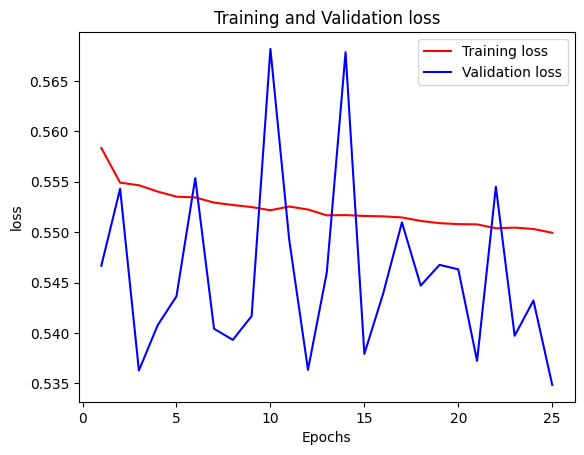

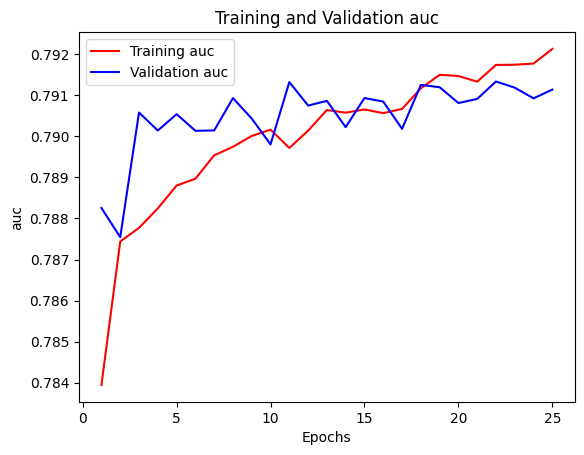

In [21]:
check_metrics(history_with_transformed_features, 'loss')
check_metrics(history_with_transformed_features, 'auc')

In [22]:
model_with_transformed_features.predict(features_val)

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.89983237],
       [0.25471476],
       [0.7706313 ],
       ...,
       [0.26052678],
       [0.6133647 ],
       [0.20497833]], dtype=float32)

In [23]:
treshold = 0.5
target_pred = [1 if i > treshold else 0 for i in model_with_transformed_features.predict(features_val)]

637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
print(f'ROC AUC на тренировочной части: {model_with_transformed_features.evaluate(features_train, target_train.to_numpy(), verbose=0)[1]}')
print(f'ROC AUC на тестовой части: {model_with_transformed_features.evaluate(features_val, target_val.to_numpy(), verbose=0)[1]}')

ROC AUC на тренировочной части: 0.7939966917037964
ROC AUC на тестовой части: 0.7911384701728821


Удаление признаков немного улучшило модель.

7. Собрав финальный датасет, который состоит из отфильтрованных (или добавленных) новых признаков, добавьте в вашу модель методы регуляризации — BatchNorm, Dropout, EarlyStopping, а также реализуйте автоматическое сохранение наилучших весов по метрике ROC_AUC на лучшей эпохе.

In [25]:
def create_regularized_model():
    model = Sequential()
    model.add(Input(shape=(features_train.shape[1], )))
    model.add(Dense(256, activation='tanh'))
    # model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='tanh'))
    # model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['auc'])
    
    return model

In [26]:
regularized_model = create_regularized_model()

monitor = 'val_auc'
early_stopping = EarlyStopping(monitor=monitor, mode='max', patience=20, restore_best_weights=True)
save_best_weights = ModelCheckpoint(filepath='.weights.h5',
                                    save_weights_only=True,
                                    monitor=monitor,
                                    mode='max',
                                    save_best_only=True)

history_regularized = regularized_model.fit(features_train, target_train.to_numpy(),
                    validation_data=(features_val, target_val.to_numpy()), 
                    epochs=100,
                    batch_size=64, 
                    class_weight={0:class_weights[0], 1:class_weights[1]},
                    callbacks=[early_stopping, save_best_weights])

Epoch 1/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - auc: 0.7648 - loss: 0.5824 - val_auc: 0.7834 - val_loss: 0.5479
Epoch 2/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.7832 - loss: 0.5596 - val_auc: 0.7888 - val_loss: 0.5354
Epoch 3/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - auc: 0.7821 - loss: 0.5586 - val_auc: 0.7888 - val_loss: 0.5538
Epoch 4/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - auc: 0.7786 - loss: 0.5623 - val_auc: 0.7912 - val_loss: 0.5520
Epoch 5/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - auc: 0.7833 - loss: 0.5571 - val_auc: 0.7892 - val_loss: 0.5563
Epoch 6/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - auc: 0.7836 - loss: 0.5604 - val_auc: 0.7876 - val_loss: 0.5462
Epoch 7/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.7858 - loss: 0.5588 - val_auc: 0.7883 - val_loss: 0.5385
Epoch 8/100
1273/1273 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - auc: 0.7832 - loss: 0.5585 - val_auc: 0.7902 - val_loss: 0.5518
Epoch 9/100
1273/1273 ━━━━━━━━

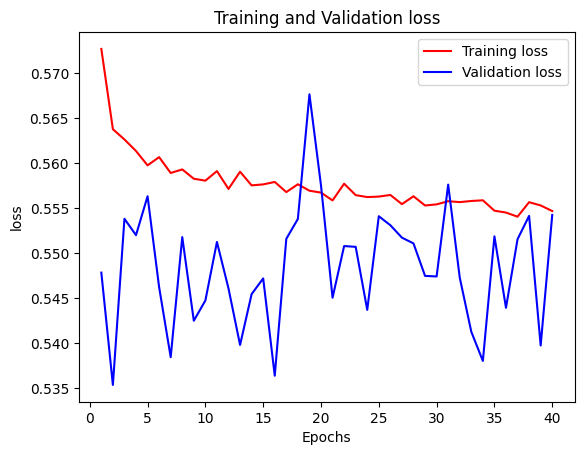

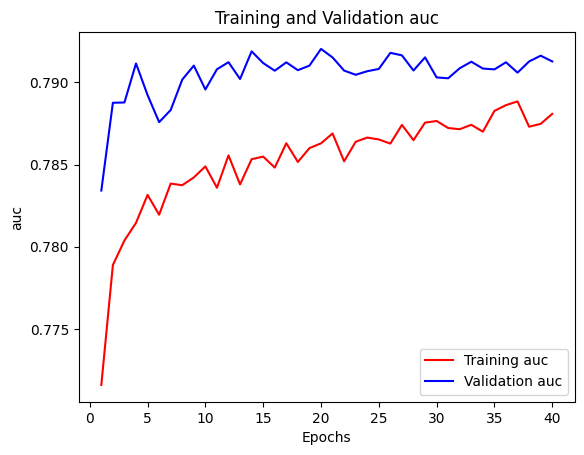

In [27]:
check_metrics(history_regularized, 'loss')
check_metrics(history_regularized, 'auc')

In [28]:
regularized_model.load_weights(".weights.h5")

In [29]:
treshold = 0.5
target_pred = [1 if i > treshold else 0 for i in regularized_model.predict(features_val)]

637/637 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


In [30]:
print(f'ROC AUC на тренировочной части: {regularized_model.evaluate(features_train, target_train.to_numpy(), verbose=0)[1]}')
print(f'ROC AUC на тестовой части: {regularized_model.evaluate(features_val, target_val.to_numpy(), verbose=0)[1]}')

ROC AUC на тренировочной части: 0.7929027080535889
ROC AUC на тестовой части: 0.7920404076576233


8. Напишите вывод по всему проекту, он должен содержать в себе:

- Какие методы регуляризации улучшили качество, а какие плохо повлияли

- Какие признаки повлияли на качество обучения (в лучшую сторону)

- Наилучшую метрику ROC_AUC на валидации

### Вывод:

- удаление признаков, сильно коррелирующих между собой, улучшило качество модели
- функция активации 'tanh' в данной модели показала себя лучше
- BatchNormalization оказал положительное влияние на качество модели
- Dropout не всегда хорошо сказывался на качестве модели
- наилучшая валидационная метрика ROC_AUC составила 0.7920404076576233 на модели с использованием методов регуляризации
